# 🦠 Metabolic modeling of bacterial isolates 🧫

 

## Setup

The setup is a bit simpler this time. We will install a small Python package that was built for the very purpose of this course and installing it will also pull in some additional commands and packages we need, for instance the metabolic modeling package [COBRAPY](https://opencobra.github.io/cobrapy) which we will use extensively.

In [1]:
!pip install -q git+https://github.com/gibbons-lab/2021_microbiome_course_utils
!bootstrap

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 37.5 MB 1.7 MB/s 
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 8.7 MB 40.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.6 MB 69.8 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 10.9 MB 69.5 MB/s 
     |████████████████████████████████| 229 kB 71.3 MB/s 
     |████████████████████████████████| 109 kB 77.1 MB/s 
     |████████████████████████████████| 7.3 MB 55.0 MB/s 
     |████████████████████████████████| 2.3 MB 59.1 MB/s 
     |████████████████████████████████| 44 kB 2.5 MB/s 
     |████████████████████████████████| 147 kB 53.3 MB/s 
     |████████████████████████████████| 68 kB 7.2 MB/s 
 

That's it. We are ready to start.

# 🧬 From Genome to Model 

## The Assembly
For our first step we will get our assembled genome. As noted before, these assemblies will not give us a singe contigious piece of DNA, but rather a set of fragmented *contigs*.

We will use the course Python package to get our own personal bacterial assembly. **Before running the code below, substitute `[YOUR NAME]` with your full name or nickname.** You can call yourself whatever you'd like, just make sure it's fairly unique. This name will be used to randomly assign you a specific genome assembly from the database. 

What organism do you get?

In [2]:
from course import gimme_genome

assembly = gimme_genome("Shiela Jimenez")

Hi, Shiela Jimenez! Welcome to the course 🎉

Saved the assembly to SRR9220197.asm1.fna.

Wow! Your assembly is SRR9220197.asm1 which is Bifidobacterium pseudocatenulatum 🤯 
By the way, the full GTDB taxonomic assignment is Bacteria | Actinobacteriota | Actinomycetia
| Actinomycetales | Bifidobacteriaceae | Bifidobacterium | Bifidobacterium pseudocatenulatum 
🤓

This will download your assembled genome and tell you which organism you are dealing with. Let's take a peak at your assembly. What do you expect it to look like?

In [3]:
!head *.fna

>k141_36 flag=1 multi=14.0000 len=1015
AACCCATCTTTGCAACGAAAAAAAAAAAAGAAAATAAAAAATAAAAAATAAAAAGACCAAATAGTAAATGGTACACTCTTACACACTATCATCCTCATCGTATATTATAATAGATATATACAATACATGTTTTTACCCGGATCATAGAATTCTTAAGACAAATAAAATTTATAGAGACTTGTTCAGTCTACTTCTCTCTAAACTAGGCCCCGGCTCCTGCCAGTACCCACTTAGAAAGAAATAAAAAAACAAATCAGACAACAAAGGCTTAATCTCAGCAGATCGTAACAACAAGGCTACTCTACTGCTTACAATACCCCGTTGTACATCTAAGTCGTATACAAATGATTTATCCCCACGCAAAATGACATTGCAATTCGCCAGCAAGCACCCAAGGCCTTTCCGCCAAGTGCACCGTTGCTAGCCTGCTATGGTTCAGCGACGCCACAAGGACGCCTTATTCGTATCCATCTATATTGTGTGGAGCAAAGAAATCACCGCGTTCTAGCATGGATTCTGACTTAGAGGCGTTCAGCCATAATCCAGCGGATGGTAGCTTCGCGGCAATGCCTGATCAGACAGCCGCAAAAACCAATTATCCGAATGAACTGTTCCTCTCGTACTAAGTTCAATTACTATTGCGGTAACATTCATCAGTAGGGTAAAACTAACCTGTCTCACGACGGTCTAAACCCAGCTCACGTTCCCTATTAGTGGGTGAACAATCCAACGCTTACCGAATTCTGCTTCGGTATGATAGGAAGAGCCGACATCGAAGAATCAAAAAGCAATGTCGCTATGAACGCTTGACTGCCACAAGCCAGTTATCCCTGTGGTAACTTTTCTGGCACCTCTAGCCTCAAATTCCGAGGGACTAAAGGATCGATAGGCCACACTTTCATGGTTTGTATTCACACTGAAAATCAAAATCAAGGGGGCTTTTACCCTTTTGTTCTACTGG

This output is divided into the ID of the contig and some additional information. `flag` denotes the contig's shape in the contig graph `flag=1` denotes the contig is standalone, `flag=2` denotes a looped path, and `flag=0` is for all other contigs. `multi` is an approximation of the coverage of the contig (how many reads cover each base on average). And `len`, unsurprisingly, is the length of the contig. Your organism will have a whole bunch of these contigs.

## The Genes

To map our genome to enzymes we will have to identify the genes encoding for these enzymes. For this, the first step is to identify all of the open reading frames (ORFs), or genes, in the genome. Luckily, this is not super hard for bacterial genomes and we can use [prodigal](https://doi.org/10.1186/1471-2105-11-119).

What is this weird `${ASSEMBLY}`? Well this is a variable that will be filled in automatically with the ID of your assembly. This way we don't have to copy and paste the name of the assembly everytime.

In [4]:
!prodigal -p single -i ${ASSEMBLY}.fna \
    -o ${ASSEMBLY}.gff -a ${ASSEMBLY}.faa -q

/bin/bash: prodigal: command not found


This will predict coding regions in the genome and generate a genome feature file (GFF), along with the amino acid sequences for the predicted proteins. This is what we will use to look for enzymes. Can you guess why we are using the protein sequences and not the nucleotide sequences?

Let's have a look at the proteins.

In [5]:
!head ${ASSEMBLY}.faa

head: cannot open 'SRR9220197.asm1.faa' for reading: No such file or directory


The FASTA headers now indicate where in the contig the gene starts and ends and gives some more info about the coding region.

## The Reconstruction

Now we have our proteins and can start building the metabolic model. Let's recall the the basics of metabolic reconstruction and what we'll need.

![reconstruction methods](https://github.com/Gibbons-Lab/isb_course_2021/raw/main/docs/models/assets/reconstruction.png)

Roughly, we need to run the following steps:

1. map the identified proteins to our universal model
2. find the model most consistent with the genomic evidence that can also produce biomass 
3. curate the model with various growth media

CARVEME can run all of these steps, but we will need to supply the required input data:

1. a list of protein sequences found within the genome
2. the specific growth medium we want to gapfill the model on

But what media should we use for curation? Well, the isolates all come from the human gut, so having a description of the available nutrients there might be helpful. We've chosen to use a medium based on the standard European diet (i.e. a 'Western diet'). Additionally, these isolates were grown in some medium in the lab in order to pick individual colonies for sequencing. Therefore, we will use the anaerobic M9 medium, which is a fairly rich medium commonly used for picking gut isolates. We have pre-prepared these media for you, so let's get them.

In [6]:
from course import gimme_media

media = gimme_media()

Okay, downloaded media to carveme_media.tsv.

Let's take a look what we got here.

In [7]:
media

,compound,medium,description,reaction,flux
0,26dap__M,western_diet_gut,average European diet adjusted for adsorption ...,EX_26dap__M_e,0.1
1,ac,western_diet_gut,average European diet adjusted for adsorption ...,EX_ac_e,0.1
2,acgam,western_diet_gut,average European diet adjusted for adsorption ...,EX_acgam_e,0.1
3,ala__L,western_diet_gut,average European diet adjusted for adsorption ...,EX_ala__L_e,0.1
4,amp,western_diet_gut,average European diet adjusted for adsorption ...,EX_amp_e,0.1
...,...,...,...,...,...
140,nh4,M9[-O2],M9 minimal medium (anaerobic),EX_nh4_e,0.1
141,ni2,M9[-O2],M9 minimal medium (anaerobic),EX_ni2_e,0.1
142,pi,M9[-O2],M9 minimal medium (anaerobic),EX_pi_e,0.1
143,so4,M9[-O2],M9 minimal medium (anaerobic),EX_so4_e,0.1


So we actually have two environmental conditions here. One describes the metabolites expected to be present in the human gut after an average European diet has passed through the small intestine. The other is a well-defined anaerobic M9 medium. We also have some flux bounds that limit the maximum uptake per hour for each of these media.

So we got our proteins and the growth media. This is all we need to build the reconstruction...right? 


---

**Houston, we have a problem 🚀**

Well it turns out we cannot run CARVEME on Google Colab, because it uses the commercial [CPLEX](https://www.ibm.com/analytics/cplex-optimizer) solver from IBM. IBM does provide free licenses to students and faculty through the [Academic Inititative](https://www.ibm.com/academic/faqs/faqs), but we can't add it to the Colab environment due to licensing restrictions 😭 

---


But no worries, we have an awesome robot friend (🤖) that can impersonate CARVEME very well. For instance, the following command looks indistinguishable from the actual command you'd normally run in CARVEME:

In [8]:
!carve -h

🤖 I'm not the real CARVEME, but will pretend that I am now...
usage: carve [-h] [--dna | --egg | --refseq] [--diamond-args DIAMOND_ARGS]
             [-r] [-o OUTPUT] [-u UNIVERSE | --universe-file UNIVERSE_FILE]
             [--cobra | --fbc2] [-n ENSEMBLE] [-g GAPFILL] [-i INIT]
             [--mediadb MEDIADB] [-v] [-d] [--soft SOFT] [--hard HARD]
             [--reference REFERENCE]
             INPUT [INPUT ...]

Reconstruct a metabolic model using CarveMe

positional arguments:
  INPUT                 Input (protein fasta file by default, see other options for details).
                        When used with -r an input pattern with wildcards can also be used.
                        When used with --refseq an NCBI RefSeq assembly accession is expected.

optional arguments:
  -h, --help            show this help message and exit
  --dna                 Build from DNA fasta file
  --egg                 Build from eggNOG-mapper output file
  --refseq              Download genome fr

So let's use it. We will have to supply the protein FASTA file, the growth media database, and the names of all the growth conditions we want to enable our bacterium to grow on.

In [9]:
!carve \
    --mediadb carveme_media.tsv --gapfill "western_diet_gut,M9[-O2]" \
    --fbc -o ${ASSEMBLY}.xml ${ASSEMBLY}.faa 

🤖 I'm not the real CARVEME, but will pretend that I am now...
Running diamond...
diamond blastp -d bigg_proteins.dmnd -q SRR9220197.asm1.faa -o 
SRR9220197.asm1.tsv -p 2
Loading universe model...
Loading media library...
Scoring reactions...
Reconstructing a single model
Gap filling for western_diet_gut, M9[-O2]...
Added 6 reactions and 2 metabolites
Done.



Our CARVEME robot did a great job! Looks just like the real deal. And you know, if it walks like a 🦆 and talks like a 🦆...

This generated a file ending in `.xml` which is an SBML file. [SBML](https://sbml.org) is the community standard for sharing metabolic models. And while we are talking about community standards let's also look into model checking a bit.

## The Model Check

We talked a bit about model curation and validation and learned that the best way to test a model is using real-world data. But, believe us, there are **plenty** of ways the model can be wrong even before you compare it to data. 

This has been known in the metabolic modeling community for quite some time, and has been discussed extensively [here](https://www.embopress.org/doi/full/10.15252/msb.20156157) and [here](https://doi.org/10.1038/s41587-020-0446-y), for example. 

Luckily, based on this prior feedback from the community, there is now a nice tool called [MEMOTE](https://memote.io), which allows you to upload an SBML model and run it through a whole battery of checks and tests. If we were to do this during the course, we would spend most of our time waiting around, so for now, we have supplied you with the pre-computed MEMOTE report for your reconstruction. To find it, look through the files on the left (📁) and download the file ending in `.html`. You can open it with any web browser and each section has a detailed explanation of what was tested and why. 

# 💻 From Model to Fluxes

Okay, now we have our metabolic reconstruction, so let's finally get to some actual metabolic modeling! We will make use of the [COBRAPY](https://opencobra.github.io/cobrapy/) package, which allows us to run a bunch of different analyses and simulations with our metabolic model.

COPRAPY is already installed in your notebook. If you need help with COBRAPY in the future, you can check out [its documentation](https://cobrapy.readthedocs.io/en/latest/).

## Metabolic models and COBRAPY

Before we actually start simulating the model let's have a look at it. We have learned that FBA builds on top of a lot of inferred information. So let's try to find this in the model we built. Here a short overview what ingredients we need to cook up an FBA result:

![flux balance analysis](https://github.com/Gibbons-Lab/isb_course_2021/raw/main/docs/models/assets/fba.png)

The first thing we have to to is to actually read the model into memory, and maybe inspect it a bit to see what is going on. **Before running the code cell, substitute `[YOUR ASSEMBLY]` with the ID of your assembly (including the `.asm1` part).** You can find the file name ending in .xml on the left (📁).

In [10]:
from cobra.io import read_sbml_model

model = read_sbml_model("SRR9220197.asm1.xml")
model

Name,SRR9220197_asm1_xml
Memory address,0x07fc377e31fd0
Number of metabolites,1426
Number of reactions,2201
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


Okay, this gives us some very basic info about the model, like the number of metabolites and reactions, and the model objective, which in our case is growth. The model has accessions for metabolites and reactions, which can be used to look up a whole bunch of information and annotations. 

The objective is described, a bit opaquely, as growth. We talked a bit before about the biomass composition and we can have a look at this by taking a peak at the biomass reaction.

In [11]:
model.reactions.Growth.reaction

'0.000223 10fthf_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 0.0001 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.450531 leu__L_c + 0.343161 lys__L_c + 0.153686 met__L_c + 0.008675 mg2_c + 0.000223 mlthf_c + 0.000691 mn2_c + 0.0001 mql8_c + 0.001831 nad_c + 0.000447 nadp_c + 0.185265 phe__L_c + 0.221055 pro__L_c + 0.000223 pydx5p_c + 0.000223 ribflv_c + 0.215792 ser__L_c + 0.004338 so4_c + 0.000223 thf_c + 0.000223 thmpp_c + 0.253687 thr__L_c + 0.056843 trp__L_c + 0.137896 tyr__L_c + 0.1 uaagmda_c + 0.144104 utp_c + 0.423162 val__L_c + 0.000341 zn2_c --> 53.95 adp_c + 53.95 h_c 

This looks like what we'd expect. From the previous MEMOTE report, we know that the total consumed mass here should add up to something around 1gDW (± 0.05gDW). You can also see that the reactions are balanced. For instance, the consumed ATP is converted into ADP. 

The short names can be a bit cryptic. There are fairly human-readable here, but if we had used gapseq or ModelSEED, these features might have looked like `cpd00027_c`. Let's get some more info on, for instance, the 42nd metabolite in the model.

In [12]:
model.metabolites[42]

Metabolite identifier,2agpe140_c
Name,2-Acyl-sn-glycero-3-phosphoethanolamine (n-C14:0)
Memory address,0x07fc373ac0290
Formula,C19H40NO7P
Compartment,C_c
In 2 reaction(s),"2AGPEAT140, 2AGPE140tipp"


Okay, this is much more informative. You get the full name of the metabolite, the molecular formula, and the reactions in the model that include this metabolite. The same kind of output can be generated for individual reactions in the model.

In [13]:
model.reactions[42]

Reaction identifier,2DDARAA
Name,2-dehydro-3-deoxy-D-arabinonate Aldolase
Memory address,0x07fc373197c50
Stoichiometry,2ddara_c <=> gcald_c + pyr_c 2-dehydro-3-deoxy-D-arabinonate <=> Glycolaldehyde + Pyruvate
GPR,k141_60_59
Lower bound,-1000.0
Upper bound,1000.0


This gives us a lot of information about the reaction, including the substrates, products, reversibility, and bounds. The GPR is the *Gene-Protein-Reaction* rule and it states under what conditions the enzyme is functional.

Do those `k*_*_*` look familiar? Exactly, those come from our assembly and gene predicton output. For instance, `k79_237_3` indicates the 3rd gene from the contig named k79_237. So we can track our contigs and genes all the way through the metabolic model.

If you want more information about a reaction you can also check out the annotations (see below).

In [14]:
model.reactions[42].annotation

{'sbo': 'SBO:0000176'}

This will give you feature IDs for other databases, if available, which can be super-helpful when trying to map results back to experimental data. This is why the presence of sufficient annotations is a major criterion for MEMOTE scoring. 

## Flux Balance Analysis

Okay, can we finally get to an actual simulation, please? 🥺 Yes! Running an FBA here is really simple. Just call `optimize()` on your model.

In [15]:
fba_solution = model.optimize()
fba_solution

,fluxes,reduced_costs
12DGR140tipp,0.0,0.000000
12DGR141tipp,0.0,0.000000
12DGR160tipp,0.0,0.000000
12DGR161tipp,0.0,0.000000
12DGR180tipp,0.0,0.000000
...,...,...
ASP1DC,0.0,-0.023751
ASPO5,0.0,0.000000
MOHMT,0.0,0.000000
NNDPR,0.0,-0.097643


There is a lot of stuff going on under the hood here, so it's kind of cool that it runs so fast. 

Here you see the predicted growth rate and the fluxes. We won't spend too much time on the reduced costs here, but they are metrics that can be helpful sometimes. The two things to know about reduced costs are: 

1. They are only different from zero if the flux is zero.
2. They quantify by how much the growth rate would be reduced if we force a flux through this reaction.

So they are kind of the cost in growth rate the organism would have to pay to get flux through that previously shut-off reaction.

This output may be a bit complex. For any solution we can also get a summary output:

In [16]:
model.summary(fba_solution)

Metabolite,Reaction,Flux,C-Number,C-Flux
3cmp_e,EX_3cmp_e,6.143,9,0.53%
4abut_e,EX_4abut_e,0.003827,4,0.00%
Larab_e,EX_Larab_e,118.1,15,16.96%
acnam_e,EX_acnam_e,7.653,11,0.81%
ade_e,EX_ade_e,7.795,5,0.37%
akg_e,EX_akg_e,13.89,5,0.66%
arg__L_e,EX_arg__L_e,11.32,6,0.65%
bz_e,EX_bz_e,0.003827,7,0.00%
ca2_e,EX_ca2_e,0.1992,0,0.00%
cl_e,EX_cl_e,0.1992,0,0.00%


This is still fairly long, but definitely looks nicer. We now see what your bacterium eats (uptake) and what proportion of the total carbon influx comes from that particular uptake (C-Flux). We get the same output for secretion. 

What is the major carbon source in for your organism in this simulation? 

Does the organism secrete carbon-rich metabolites? If yes, which ones?

<br>

---

**Break time ☕  🥪** 

---


# 🌍 Comparative Reverse Ecology

Why are we interested in those uptake fluxes? Well, they are the recipe for an organism's growth, and thus, related to its evolutionary history (i.e. to the environmental conditions that it has adapted to live in). They are not solely what is present in the organism's surroundings, but the actual consumption preferences of that organism within a particular environment.

When we started constructing our models, we had a description of the (metabolic) environment (the available nutrients) and our organism's genome. But now, suddenly, we learn something about how our organism interacts with the environment. And that means we learned something about its **ecology** 🤯

Inferring information about an organism's ecology from genomic data is called [Reverse Ecology](https://en.wikipedia.org/wiki/Reverse_ecology). Check these [slides](https://gibbons-lab.github.io/isb_course_2021/models/#/26) for some more discussion on this point.

Before we get there, however, we need to curate our model a bit...

## Getting realistic: PFBA and media

As we noted, the particular flux solutions are often not unique and there may be many other solutions. To alleviate this let's use parsimonious FBA (pFBA), which minimizes the total import flux and the amount of enzymes required for growth.

![parsimonious FBA](https://github.com/Gibbons-Lab/isb_course_2021/raw/main/docs/models/assets/pfba.png)

pFBA is part of COBRAPY and will give us a new solution.

In [17]:
from cobra.flux_analysis import pfba

pfba_solution = pfba(model)
model.summary(pfba_solution)

Metabolite,Reaction,Flux,C-Number,C-Flux
3cmp_e,EX_3cmp_e,6.143,9,0.59%
4abut_e,EX_4abut_e,0.003827,4,0.00%
Larab_e,EX_Larab_e,118.1,15,18.81%
acnam_e,EX_acnam_e,7.653,11,0.89%
ade_e,EX_ade_e,7.795,5,0.41%
akg_e,EX_akg_e,13.89,5,0.74%
arg__L_e,EX_arg__L_e,11.32,6,0.72%
bz_e,EX_bz_e,0.003827,7,0.00%
ca2_e,EX_ca2_e,0.1992,0,0.00%
cl_e,EX_cl_e,0.1992,0,0.00%


We got our first real results -- awesome! But are they realistic? Remember that we stated that the biomass flux is essentially equivalent to the growth rate. We can convert the growth rate $\mu$ to the doubling time with the formula

$$
\tau = \ln(2) / \mu
$$

In [18]:
from math import log

tau = log(2) / fba_solution.objective_value
print(f"The predicted dubling time is {tau:.2g} hours ({tau*60*60:.2g} seconds).")

The predicted dubling time is 0.018 hours (65 seconds).


That probably looks a bit fast, right? So if you complained that this growth rate was too high in the Slack chat (or to yourself when we ran the first FBA), then you should take a few seconds to find the mirror closest to you and tell yourself that you are, indeed, a smart cookie, because you were absolutely right! No bacterium doubles that fast.

But why is it predicted to grow so fast? 

## The Environment and Nutrient Preferences

Well, we did not impose particular environmental conditions yet. So what did the model use? Let's look at the first uptake reaction.

In [19]:
model.exchanges[0]

Reaction identifier,EX_12ppd__R_e
Name,R_EX_12ppd__R_e
Memory address,0x07fc371af4d50
Stoichiometry,"12ppd__R_e <=> (R)-Propane-1,2-diol <=>"
GPR,
Lower bound,-1000.0
Upper bound,1000.0


You see that the reaction is formulated into the export reaction (i.e. positive values denote the rate at which the compounds disappears). So, a negative flux denotes import and the lower bound dictates the largest possible import, which is 1000 mmol/(gDW h), in this case. So one mole per hour per gram of bacteria. So about $6\cdot 10^{23}$ molecules per hour, hmmmmmm 🤨

But we gapfilled the model with realistic media! So let's use those this time. Since the gut environment is probably a bit more interesting let's use this one. We will read in the environmental conditions using the `pandas` package and then format it a bit.

In [20]:
import pandas as pd

media_db = pd.read_csv("carveme_media.tsv", sep="\t")
media_db.index = media_db.reaction
western_diet = media_db[media_db.medium == "western_diet_gut"]
western_diet

,compound,medium,description,reaction,flux
reaction,,,,,
EX_26dap__M_e,26dap__M,western_diet_gut,average European diet adjusted for adsorption ...,EX_26dap__M_e,0.100000
EX_ac_e,ac,western_diet_gut,average European diet adjusted for adsorption ...,EX_ac_e,0.100000
EX_acgam_e,acgam,western_diet_gut,average European diet adjusted for adsorption ...,EX_acgam_e,0.100000
EX_ala__L_e,ala__L,western_diet_gut,average European diet adjusted for adsorption ...,EX_ala__L_e,0.100000
EX_amp_e,amp,western_diet_gut,average European diet adjusted for adsorption ...,EX_amp_e,0.100000
...,...,...,...,...,...
EX_amylose_e,amylose,western_diet_gut,average European diet adjusted for adsorption ...,EX_amylose_e,0.000047
EX_glc__D_e,glc__D,western_diet_gut,average European diet adjusted for adsorption ...,EX_glc__D_e,0.014899
EX_pect_e,pect,western_diet_gut,average European diet adjusted for adsorption ...,EX_pect_e,0.000033


Here, the `flux` columns denotes the upper bound for the uptake flux. You can see that those are much smaller than 1000 mmol/(gDW h).

Let's apply this medium to our model. It's easy! We just set the model medium to the flux bounds. However, some of the metabolites or transport reactions may not be present in the model. So we will first filter it by the exchange reactions that can be found in the model.

In [21]:
exchange_ids = [r.id for r in model.exchanges]
western_diet_found = western_diet[western_diet.reaction.isin(exchange_ids)]

model.medium = western_diet_found.flux

Now let's run the PFBA again.

In [22]:
diet_sol = pfba(model)
model.summary(diet_sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
acgam_e,EX_acgam_e,0.1,8,8.61%
acmana_e,EX_acmana_e,0.1,8,8.61%
acnam_e,EX_acnam_e,0.1,11,11.84%
ade_e,EX_ade_e,0.007591,5,0.41%
ala__D_e,EX_ala__D_e,0.1,3,3.23%
ala__L_e,EX_ala__L_e,0.1,3,3.23%
arab__L_e,EX_arab__L_e,0.01788,5,0.96%
arg__L_e,EX_arg__L_e,0.01099,6,0.71%
asn__L_e,EX_asn__L_e,0.008956,4,0.39%
asp__L_e,EX_asp__L_e,0.01267,4,0.55%


This should have changed the doubling time.

In [23]:
tau = log(2) / diet_sol.fluxes["Growth"]
print(f"The new doubling time is {tau:.2g} h.")

The new doubling time is 19 h.


That changed quite a bit, didn't it? What are the major carbon sources this time? 

We can also subet the fluxes so we get only the uptake fluxes.

**Remember:** In our model, uptakes are exchange reactions with negative flux values. 

In practice the solver will not be able to distinguish very small values from zero (due to [floating-point arithmetic](https://docs.python.org/3/tutorial/floatingpoint.html)). Therefore, we will consider uptakes to be 'active' if they are smaller than -1e-6. 

Calling `head()` will only show the first few fluxes.

In [24]:
uptake = diet_sol.fluxes[diet_sol.fluxes.index.isin(exchange_ids) & (diet_sol.fluxes < -1e-6)]
uptake.head()

EX_acgam_e    -0.100000
EX_acmana_e   -0.100000
EX_acnam_e    -0.100000
EX_ade_e      -0.007591
EX_ala__D_e   -0.100000
Name: fluxes, dtype: float64

This looks interesting and quantifies the expected uptake of metabolites in the gut to achieve the optimal growth rate. These import values are actual proportions of consumed nutrients, which may be quite different for each individual organism in the gut. 

Let's make this a clean table and also add in the human-readable metabolite names.

In [25]:
uptake_nice = uptake.to_frame()
uptake_nice["reaction"] = uptake.index
uptake_nice["metabolite"] = [model.reactions.get_by_id(rid).reactants[0].name for rid in uptake.index]
uptake_nice.sort_values(by="fluxes").head()

,fluxes,reaction,metabolite
EX_acgam_e,-0.1,EX_acgam_e,N-Acetyl-D-glucosamine
EX_ser__L_e,-0.1,EX_ser__L_e,L-Serine
EX_gam_e,-0.1,EX_gam_e,D-Glucosamine
EX_so4_e,-0.1,EX_so4_e,Sulfate
EX_ala__L_e,-0.1,EX_ala__L_e,L-Alanine


## Comparative Reverse Ecology

Now, let's compare all the uptake and secretion rates that everyone in the class has estimated. For that, let's just collect everybody's exchange results across the entire course. Easy peasy.

In [26]:
from course import gimme_exchanges

exchanges = gimme_exchanges()
exchanges

🔨 Sure, let me collect them from everybody real quick...

Okay, summarized all exchange fluxes to all_exchanges.csv.

,assembly,reaction,flux,metabolite,species,classification,genus
0,SRR9205533.asm1,EX_12ppd__S_e,0.014899,"(S)-Propane-1,2-diol",Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
1,SRR9205533.asm1,EX_2mpa_e,1.063572,2 methylpropanoic acid,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
2,SRR9205533.asm1,EX_4abut_e,0.018000,4-Aminobutanoate,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
3,SRR9205533.asm1,EX_acgam_e,-0.007224,N-Acetyl-D-glucosamine,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
4,SRR9205533.asm1,EX_ala__D_e,-0.100000,D-Alanine,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
...,...,...,...,...,...,...,...
75084,SRR9275565.asm1,EX_ura_e,-0.010706,Uracil,Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides
75085,SRR9275565.asm1,EX_val__L_e,-0.018000,L-Valine,Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides
75086,SRR9275565.asm1,EX_xyl__D_e,-0.017878,D-Xylose,Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides
75087,SRR9275565.asm1,EX_xylan4_e,-0.000032,"Xylan (4 backbone units, 1 glcur side chain)",Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides


Note that this includes uptake and secretion fluxes. As discussed before, transport reactions are formulated in the export direction, so negative fluxes denote uptake and positive fluxes denote secretion.

Let's visualize this. We can start by drawing a heatmap of all the uptake fluxes. For this we will filter the table by uptake and use the absolute values.

In [27]:
uptake = exchanges[exchanges.flux < 0].copy()
uptake.flux = uptake.flux.abs()
uptake

,assembly,reaction,flux,metabolite,species,classification,genus
3,SRR9205533.asm1,EX_acgam_e,0.007224,N-Acetyl-D-glucosamine,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
4,SRR9205533.asm1,EX_ala__D_e,0.100000,D-Alanine,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
5,SRR9205533.asm1,EX_ala__L_e,0.100000,L-Alanine,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
6,SRR9205533.asm1,EX_arab__L_e,0.017878,L-Arabinose,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
7,SRR9205533.asm1,EX_arg__L_e,0.015000,L-Arginine,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Alistipes
...,...,...,...,...,...,...,...
75084,SRR9275565.asm1,EX_ura_e,0.010706,Uracil,Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides
75085,SRR9275565.asm1,EX_val__L_e,0.018000,L-Valine,Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides
75086,SRR9275565.asm1,EX_xyl__D_e,0.017878,D-Xylose,Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides
75087,SRR9275565.asm1,EX_xylan4_e,0.000032,"Xylan (4 backbone units, 1 glcur side chain)",Bacteroides uniformis,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteroides


Now let's convert this output into a matrix that we can visualize as a heatmap. One issue is that flux values between different metabolites can vary across many orders of magnitude. For instance water (H₂O) can often just diffuse passively into the cell with very large fluxes, but importing large molecules will always be much slower. There are many way to normalize these fluxes. For instance, one could scale it by molecular weight of a compound. However, a very easy way is to just log-transform the fluxes. We will stick with that for now.

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


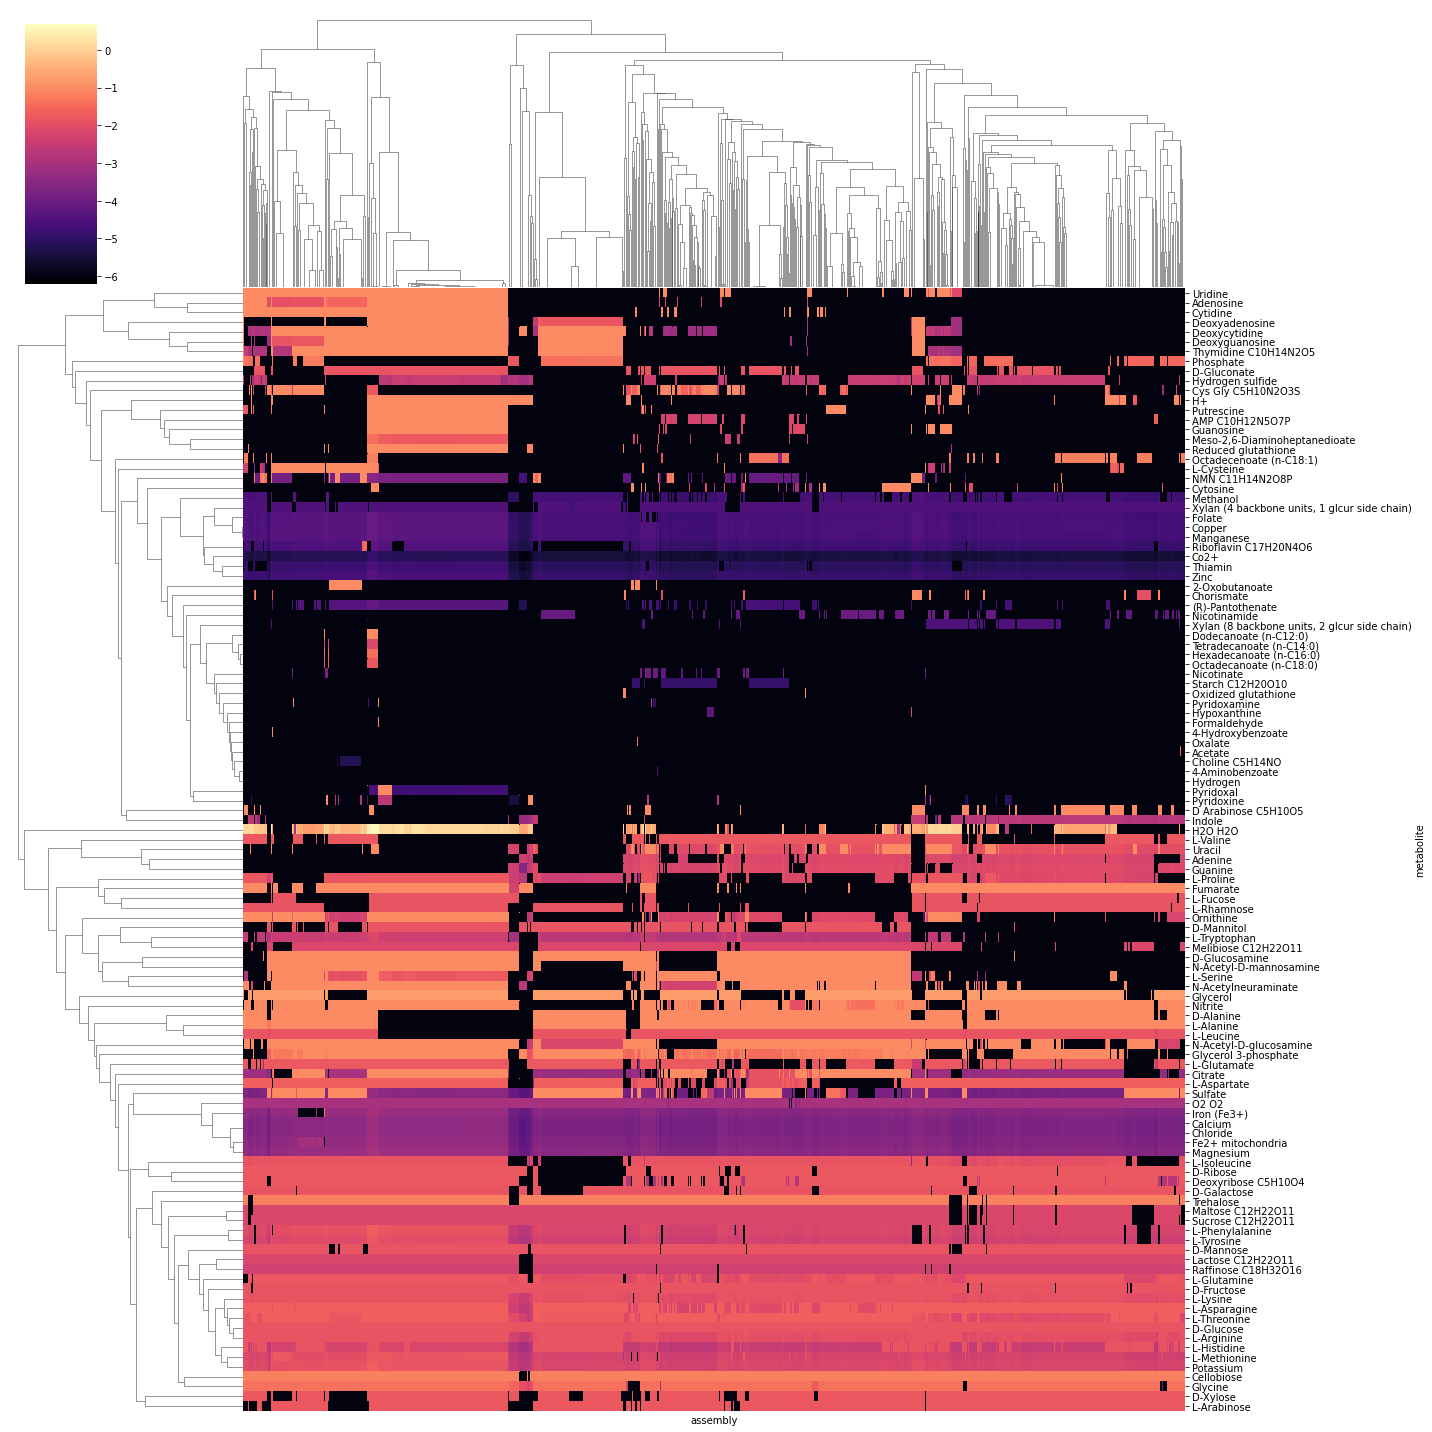

In [28]:
from seaborn import clustermap
from numpy import log10

uptake_matrix = uptake.pivot_table(
    index="metabolite", 
    columns="assembly", 
    values="flux", 
    fill_value=1e-6
)
clustermap(
    log10(uptake_matrix), 
    cmap="magma", 
    xticklabels=False, 
    yticklabels=True, 
    figsize=(20, 20)
)

There are several things we can learn from this heatmap. Rows denote individual metabolites and columns denote individual isolates. The column dendrogram groups organisms with similar uptake fluxes together (i.e. organisms with similar metabolic requirements) and the row dendrogram groups metabolites that behave similarly across organisms (i.e. metabolites that tend to be taken up together).


You can see that even though all isolates were subjected to the same environmental conditions they use very different strategies to produce biomass. Rows that are very "patchy" denote metabolites that are only necessary for a small number of isolates, while homogeneously colored rows denote metabolites that are required by all isolates to form biomass.

One way to interpret the set of uptake fluxes for a single organism is as the realized growth niche of that organism in the gut of a human consuming an average European diet. One thing we could expect is that this niche is fairly conserved within a species. In ecology this is known as [*phylogenetic niche conservatism*](https://en.wikipedia.org/wiki/Phylogenetic_niche_conservatism). To investigate this phenomenon, let's have a look at *Phocaeicola vulgatus*, which is the recently renamed `Bacteroides vulgatus`, one of the most abundant taxa in the human gut. We will rotate the heatmap into a horizontal layout this time, so that the rows now denote isolates and columns denote metabolites. 

For this, we first generate a table that contains the annotatons for all isolates with the same order as our uptake matrix. We can then use this to filter the matrix by specific taxa.

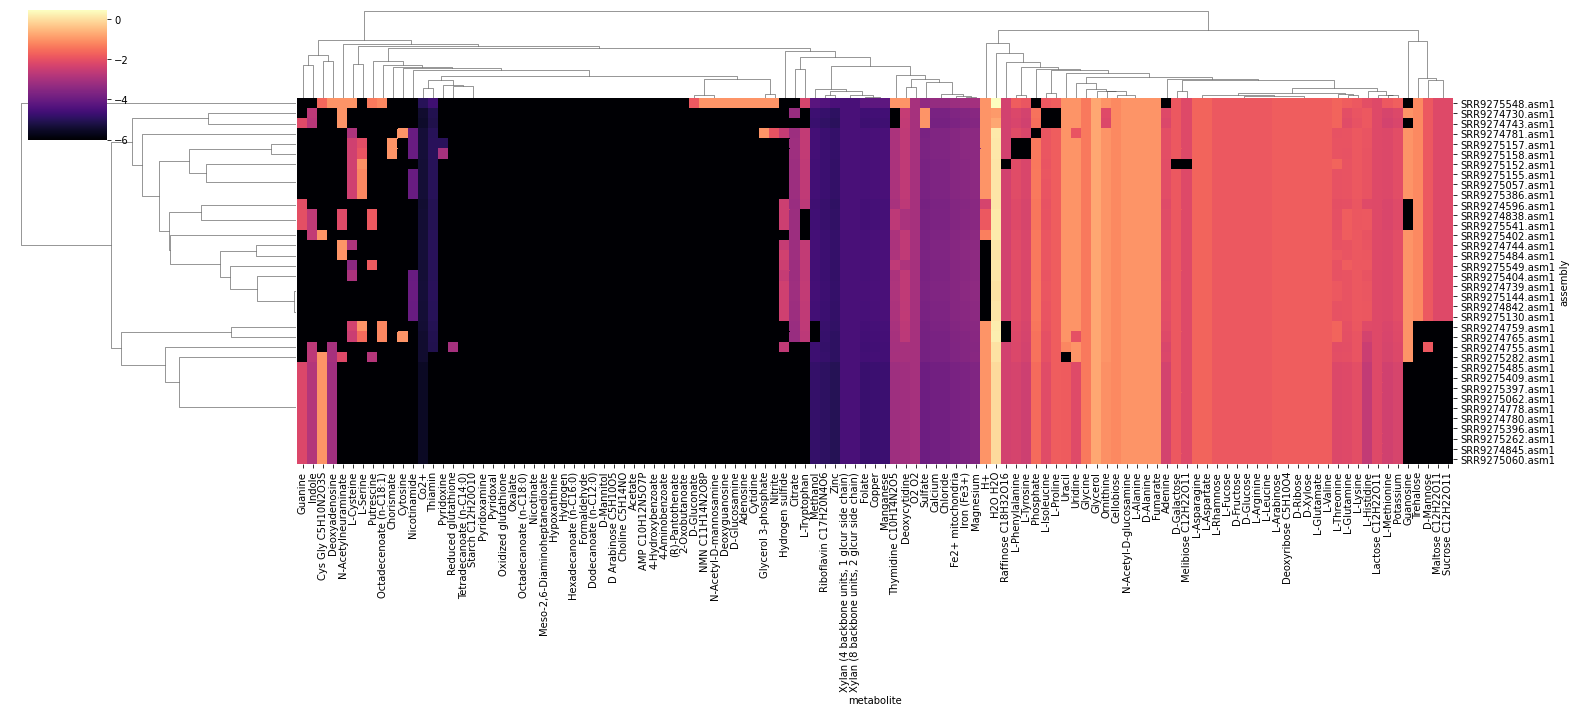

In [29]:
isolates = uptake[["assembly", "genus", "species", "classification"]].drop_duplicates()
isolates.index = isolates.assembly
isolates = isolates.loc[uptake_matrix.columns, :]

phocaeicola = uptake_matrix.loc[:, isolates.species == "Phocaeicola vulgatus"]
clustermap(
    log10(phocaeicola.T), 
    cmap="magma", 
    xticklabels=True, 
    yticklabels=True, 
    figsize=(22, 10)
)

At first glance, we see that the majority of uptakes seem to be identical for *Phocaeicola vulgatus* isolates. However, there are still some differences, indicating that an organisms' exact niche preferences can be strain-specific. 



But this is only one species in our data set. It would be much more interesting to look at all of them, so can we do better?

## Niche maps

Probably, but we might have to drop a bit of information in the visualization. If we move away from individual metabolites we can reduce our question to the following:

> How close are organismal growth niches to one another?

Just like a map can help you find the nearest grocery store to your house, we can build a map of niche distances for our growth utpake fluxes to identify organisms that are closest to one another in niche space. Thinking back to the course from yesterday, we already talked a bit about how to visualize multi-dimensional beta-diversity distances. 

We will employ a similar approach today, using a method called UMAP ("map" is even in the name). This is a non-linear approach that will try to estimate the best possible arrangement of uptake profiles in two dimensions (2D) that is consistent with actual multi-dimensional niche distances. Let's reduce each uptake profile to two coordinates in 2D space (like GPS coordinates). UMAP has a few parameters that can alter the visualization which are [explained here](https://umap-learn.readthedocs.io/en/latest/parameters.html). We will only adjust the minimum distance between points in the final projection because we already know that many uptake profiles are very similar and we don't want them to be piled on top of each other.

In [30]:
from umap import UMAP

results = UMAP(min_dist=1).fit_transform(log10(uptake_matrix.T))
reduced = pd.DataFrame({"UMAP 1": results[:, 0], "UMAP 2": results[:, 1]}, index=uptake_matrix.columns)
reduced

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,UMAP 1,UMAP 2
assembly,,
SRR9205533.asm1,10.943582,22.090073
SRR9205534.asm1,34.650661,15.929279
SRR9205536.asm1,0.137956,20.721626
SRR9205537.asm1,34.194191,15.131787
SRR9205538.asm1,0.198036,20.772495
...,...,...
SRR9275558.asm1,-7.312503,-11.380914
SRR9275559.asm1,-5.794024,-10.640738
SRR9275562.asm1,-5.490802,-9.778868


Now we will merge this with the taxonomy information from the assemblies/isolates.

In [31]:
reduced = pd.concat([isolates, reduced], axis=1)
reduced

,assembly,genus,species,classification,UMAP 1,UMAP 2
assembly,,,,,,
SRR9205533.asm1,SRR9205533.asm1,Alistipes,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,10.943582,22.090073
SRR9205534.asm1,SRR9205534.asm1,Alistipes,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,34.650661,15.929279
SRR9205536.asm1,SRR9205536.asm1,Alistipes,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,0.137956,20.721626
SRR9205537.asm1,SRR9205537.asm1,Alistipes,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,34.194191,15.131787
SRR9205538.asm1,SRR9205538.asm1,Alistipes,Alistipes onderdonkii,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,0.198036,20.772495
...,...,...,...,...,...,...
SRR9275558.asm1,SRR9275558.asm1,Bifidobacterium,Bifidobacterium longum,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,-7.312503,-11.380914
SRR9275559.asm1,SRR9275559.asm1,Bifidobacterium,Bifidobacterium longum,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,-5.794024,-10.640738
SRR9275562.asm1,SRR9275562.asm1,Bifidobacterium,Bifidobacterium longum,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,-5.490802,-9.778868


This output can now be visualized on a 2D map and we can color the points using some additional information. For example, let's use the genus annotations of the isolates.

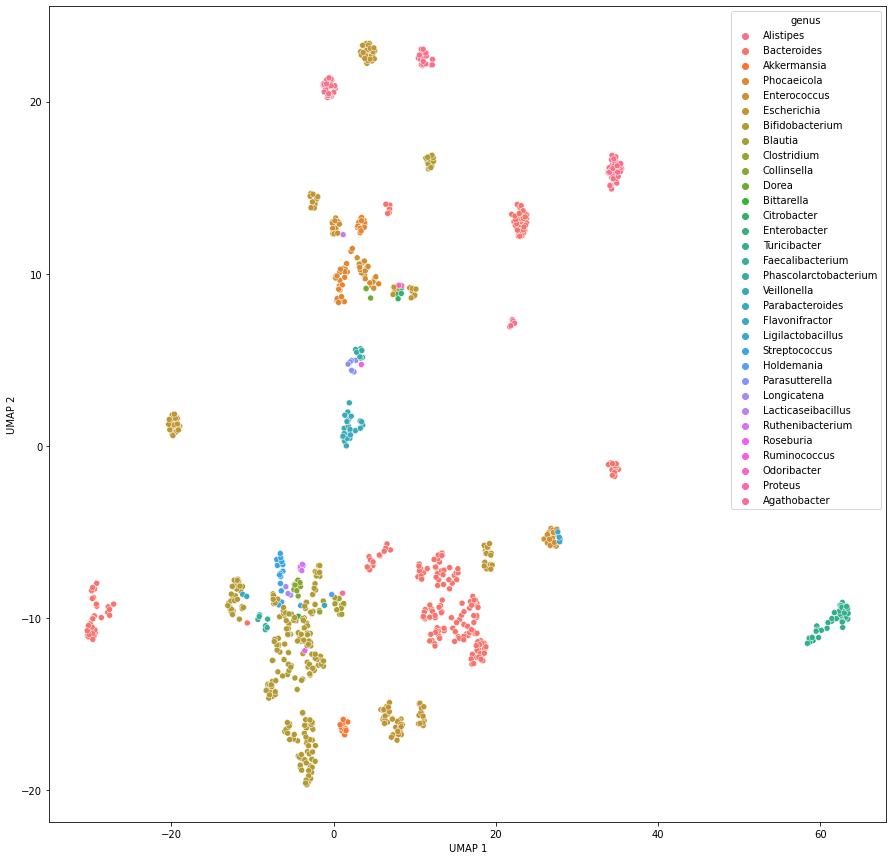

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))  # <-- this makes the figure larger

reduced["genus"] = reduced.species.str.split(" ").str[0]
sns.scatterplot(
    x="UMAP 1", 
    y="UMAP 2", 
    hue="genus", 
    data=reduced
)

So we see that there is definitely a tendency for niches to be similar within a genus. But not always. Let's have a look at the genus *Bacteroides*, for instance.

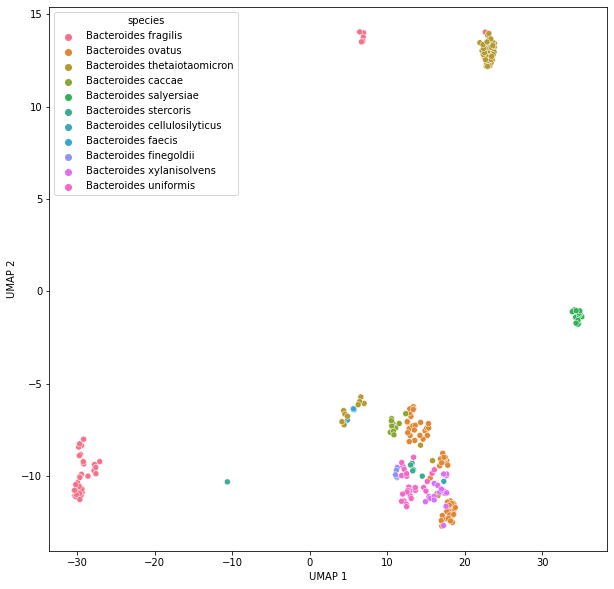

In [33]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="UMAP 1", 
    y="UMAP 2", \
    hue="species", 
    data=reduced[reduced.genus == "Bacteroides"]
)

As you can see there is a pretty discrete set of growth niches, but they do not separate strictly by species. Looking at this plot, what would be your prediction for the coexistence of these species in a single individual's gut?

**Hint:** What happens if you and four of your friends all want the last chocolate chip cookie?

**However**, there is a major drawback here that we need to consider. What could it be?

# Exercise

## Niche variability

Let's finish by putting some hard numbers on the degree of niche conservatism across taxa. On the first day of the course we already learned how to run statistical tests on differences in beta-diversity distances between groups of samples: PERMANOVA. We can't rely on Qiime 2 here, so we will use [scikit-bio](http://scikit-bio.org/). 

We will start by actually calculating the distances between uptake profiles for each isolate (i.e. the equivalent to beta-diversity in metabolic niche space). here we use the `pdist` function from [scipy](https://www.scipy.org/) which uses Euclidean distances by default. So it's probably best to log-transform again.

In [ ]:
from scipy.spatial.distance import pdist
from skbio.stats.distance import DistanceMatrix

isolates.index = isolates.assembly
D = DistanceMatrix(
    pdist(log10(uptake_matrix).T), 
    ids=uptake_matrix.columns
)
D.shape

(979, 979)

Now we can run our PERMANOVA. Let's test whether the genus explains a significant fraction of variability in the growth niches. The `scikit-bio` PERMANOVA does not calculate the explained variance (R²) by default, so we will add it in here with a helper function.

In [ ]:
from skbio.stats.distance import permanova
from course import add_r_squared

perm_results = permanova(D, grouping=isolates, column="genus")
add_r_squared(perm_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     979
number of groups                 32
test statistic              73.1804
p-value                       0.001
number of permutations          999
R²                         0.712267
Name: PERMANOVA results, dtype: object

In [ ]:
perm_results = permanova(D, grouping=isolates, column="species")
add_r_squared(perm_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     979
number of groups                 61
test statistic              80.0303
p-value                       0.001
number of permutations          999
R²                         0.841865
Name: PERMANOVA results, dtype: object

How do you interpret the result? Also substitute the tested rank to species by changing the `column="..."` part in the code above. 

> What do you observe for the R²? 

As we can see explained variance increases from 71% to 84% when using the species instead of the genus level.

> How do you intepret the results when comparing the genus and species level?

The results are mostly consistent with phylogenetic niche conservatism because going to a finer taxonomic level also explains more of the variation in inferred niches across genomes. However, in very strict niche conservatism we would expect that the niches are even more similar than the species. Bacterial species tend to share [>95% identity in the core genome](https://www.nature.com/articles/s41467-018-07641-9). Overall, while we find evidence for phylogenetic niche conservatism, our results also indicate that some of the variation in niche is not correlated with the phylogeny. 

> What is your interpretation of the unexplained variance 1-R²? 

Every single niche has an associated strain, so the strains necessarily will explain 100% of the niche variance. This means, that about 16% of the niche variability happens on the strain level (i.e. beyond the species level). This is still quite a bit of variation. So how is this possible if strains in the same species share >95% of the core genome? Well, one reason is that small differences can have large impact. A single missing enzyme might block an entire pathway, thus shifting the overall nutrient preferences of an organism. The other reason is that a lot of metabolic genes are often located in the assessory genome. In some instance strains from the same species might differ in up to 30% of their enzymes just because of genes in the assessory genome. Furthermore, unrelated strains can sometimes obtain the same enzymes or transporters through horizontal gene transfers.